# Solid brake disc simulation

The project is about the heat transfer condition when the car is braking. The heat energy will be generated when the brake disc is clamped by calipers. This project is based on heat transfer equation, 2D Heat conduction and Boltzmann radiation equation. The whole simulation's propuse is to tell whether the brake will fail within certain brake time and to tell the max temperature of the brake disc. So this simulation is of great importance for automobile safety. Do you wanna know? Let's get start!

## brief introduction of heat generation process

calculate the heat generation power(heat flux between callipers and discs) 

$$q_x=\int_{r_o}^{r_i}2{\pi}rf_rp_{max}\left(\frac{n2{\pi}}{60}\right)rNdr$$

integrate the function and solve q to achieve the heat flux on the surface of the brake disc (unit $W$)

$$q_x=\frac{Nf_r}{45}np_{max}\pi^2\left(r_o^3-r_i^3\right)$$

The heat generation demo is as follows. The callipers rub with disc and there are normal force between the disc and callipers so heat will be generated according to the equation:$Q=F_Nf_r$  ($F_N$ is the normal force and $f_r$ is the friction coefficient). 

<img src='./brake disc.jpg'>
#### Figure 1. brake disc heat generation. 

## 2D Heat conduction

The 2D heat conduct equation is as follows:
$$\frac{{\delta}T}{{\delta}t}={\alpha}\left(\frac{{\delta^2}T}{{\delta}x^2}+\frac{{\delta^2}T}{{\delta}^2y}\right)$$

$\alpha={1.54}*10^{-5}$ is the thermal diffusivity, which equals to $\alpha=\frac{\kappa}{{\rho}C_p}$. $\kappa=50\left(J/(Km)\right)$ is the thermal conductivity, $\rho=7.2*10^3\left(kg/m^3\right)$ is the density of the material and $C_p=460.548\left(J/(kgK)\right)$ is the heat capacity. 

let's expand the heat conduction equation by central differential method. 

$$\frac{T^{n+1}_{i,j} - T^n_{i,j}}{\Delta t} = \alpha \left( \frac{T^n_{i+1, j} - 2T^n_{i,j} + T^n_{i-1,j}}{\Delta x^2} + \frac{T^n_{i, j+1} - 2T^n_{i,j} + T^n_{i,j-1}}{\Delta y^2}\right)$$

solve $T_{i,j}^{n+1}$

$$T^{n+1}_{i,j}= T^n_{i,j} + \alpha \left( \frac{\Delta t}{\Delta x^2} (T^n_{i+1, j} - 2T^n_{i,j} + T^n_{i-1,j}) +frac{\Delta t}{\Delta y^2} (T^n_{i, j+1} - 2T^n_{i,j} + T^n_{i,j-1})\right)$$

## problem analysis
<img src='heat flux.PNG'width='300px'>
### Figure 2. Heat flux demo

According to Figure 2, cute the cross section area of the disc and pick up the upper half of the cross section which has the hight $50mm$ and the width $11mm$. The heat flux comes from the right and left boundary. Besides, there are also heat flux generated by the radiation from brake disc to surrounding area which is $E$ the Boltzmann radiation, which is happened on both side of the disc. The Boltzmann radiation equation is as follows. infrared emissitivity: $\varkappa=0.5$ ; Boltzmann constant:$\delta_b=5.76*10^{-8}W/(m^2{K^4})$

$$E={\varepsilon}{\delta_b}\left(T_1^4-T_2^4\right)$$          
$$q_x=\frac{Nf_r}{45}np_{max}\pi^2\left(-r_i^3+r_o^3\right)$$

## Boundary condition

Because the upper boundary is very narrow the heat flux on the upper boundary is neglected. According to heat transfer equation the boundary condition is calculated as follows. 

$$q_x-E=KA\frac{{\Delta}T}{{\Delta}X}$$

Solve(left side): $$T_{0,j}=\frac{q_x}{KA}{\delta_x}+T_{1,j}-\frac{E}{K}\delta_x$$
$$(E={\varepsilon}{\delta_b}\left(T_{0,j}^4-T_{298}^4\right))$$ 


Solve(right side)$$T_{end,j}=\frac{q_x}{KA}{\delta_x}+T_{end-1,j}-\frac{E}{K}\delta_x$$
$$(E={\varepsilon}{\delta_b}\left(T_{-1,j}^4-T_{298}^4\right))$$ 

## Coding

import the coding packages. 

In [1]:
import numpy
import sympy
from sympy import *
from matplotlib import pyplot, cm
%matplotlib inline
from matplotlib import rcParams
rcParams['font.family'] = 'serif'
rcParams['font.size'] = 16

In [2]:
def ftcs(T, nt, alpha, dt, dx, dy, K, q, E, A):
    
    for n in range(25000):
        Tn = T.copy()
        T[1:-1,1:-1] = Tn[1:-1, 1:-1] + \
            alpha*dt/dx**2 * (Tn[1:-1,2:] - 2*Tn[1:-1,1:-1] + Tn[1:-1,:-2]) + \
            alpha*dt/dy**2 * (Tn[2:,1:-1] - 2*Tn[1:-1,1:-1] + Tn[:-2,1:-1])
        
        #heat radiation
        varepsilon = 0.5 # infrared emissitivity. 
        delta = 5.76*10**(-8) # boltzmann constant
        E_left = varepsilon*delta*(T[:,0]**4 - 298**4)
        E_right = varepsilon*delta*(T[:,-1]**4 - 298**4)
        
        # Neumann Boundary Conditions
        #left boundary
        T[:, 0] = T[:, 1] + dx*q/(K*A) - dx*E_left[:]/K
        #right boundary
        T[:,-1] = T[:, -2] + dx*q/(K*A) - dx*E_right[:]/K
        #upper boundary 
        T[-1, :] = T[-2, :]
        #bottom boundary
        T[0, :] = T[1, :]
        
        #check if the brake reach the fail temperature
        if numpy.max(abs(T)) >= 8230:
            print("the brake fail at time {0:.2f}s.".format(dt*n))
            break
    if numpy.max(abs(T)) <=823:
        print("the brake is still working at time {0:.2f}s.'our brake disc survived!!!".format(dt*n))
    return T

In [3]:
#parameters of the solid brake disc (brembo)
r_i = 81.1/1000 #m    #inner circular radius
r_o = 131.1/1000 #mm    #outor circular radius
b = 11/1000 #mm        #thickness of disc
H = r_o - r_i  #mm width of the disc

nx = 110
ny = 500
nt = 1000

x = numpy.linspace(0, b, nx)
y = numpy.linspace(0, H, ny)

dx = b/(nx-1)
dy = H/(ny-1)

alpha = 1.54e-5   #thermal diffusivity(calculated in heat conduction part)
K = 50    #W/Km thermal conductivity

f_r = 0.2   #coefficient of friction. 
p_max = 13e5 #unite pa
n = 420      #average rpm of a car tire with speed 60mph 

Ti = numpy.ones((ny, nx))*298   # kelvin temperature

In [4]:
q = f_r*n*p_max*(numpy.pi**2)*(r_o**3 - r_i**3)/45
q

41190.37720745125

In [5]:
#surface area of the disc
A = numpy.pi*(r_o**2 - r_i**2)
A

0.033332298054587706

In [6]:
sigma = 0.25
dt = sigma*min(dx, dy)**2/alpha
T = ftcs(Ti.copy(), nt, alpha, dt, dx, dy, K, q, E, A)

the brake is still working at time 4.07s.'our brake disc survived!!!


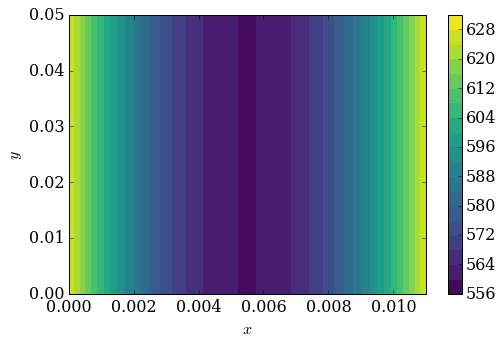

In [7]:
X, Y = numpy.meshgrid(x, y)
pyplot.figure(figsize=(8,5))
pyplot.contourf(X,Y,T,20,cmap=cm.viridis)
pyplot.xlabel('$x$')
pyplot.ylabel('$y$')
pyplot.colorbar();

In [8]:
T_max = numpy.max(abs(T))
T_max

628.19749500160003

## Conclusion

The numerical solution of this method is 628.2 Kelvin  (355.2C) and the anaytical solution according to paper 'Temperature Profile in a Disc Brake' in the reference under 4 second's brake time is 603.6K (330.6C). So the numerical condition is reliable. The reason of the difference might come from the neglection of radiation on the edge of the disc and the heat transfer between disc and axle. 

## Reference

Juvinall, R. C., & Marshek, K. M. (2000). Fundamentals of machine component design. New York: Wiley.

Mercedes 190D Brakes. (n.d.). Retrieved December 13, 2016, from http://www.partsgeek.com/mmparts/brakes/mercedes/190d.html

Retrieved December 13, 2016, from https://m.youtube.com/

B. (2006). Airbus A380-800 Brake test. Retrieved December 13, 2016, from http://www.youtube.com/watch?v=m1dv_y_3EK0

Brake System and Upgrade Selection. (n.d.). Retrieved December 13, 2016, from http://www.stoptech.com/technical-support/technical-white-papers/brake-system-and-upgrade-selection

OT- Force at the brake caliper. (n.d.). Retrieved December 13, 2016, from http://www.practicalmachinist.com/vb/general/ot-force-brake-caliper-188183/

Disc brake. (n.d.). Retrieved December 13, 2016, from https://en.wikipedia.org/wiki/Disc_brake

1           Introduction of brake. (n.d.). Retrieved December 13, 2016, from http://www.materia.coppe.ufrj.br/sarra/artigos/artigo10660/

Emissivity Coefficients of some common Materials. (n.d.). Retrieved December 13, 2016, from http://www.engineeringtoolbox.com/emissivity-coefficients-d_447.html

Vehicle Stopping Distance - National Association of City ... (n.d.). Retrieved December 13, 2016, from http://www.bing.com/cr?

Brake Failure Analysis. (n.d.). Retrieved December 13, 2016, from http://www.crashforensics.com/brakefailure.cfm

Reddy, K. V. (2010, June 15). Temperature Profiles in a Disc Brake. Application and Applied Mathematics, 5, 239-254. Retrieved from http://pvamu.edu/aam

Talati, F., & Jalalifar, S. (2009). Analysis of heat conduction in a disk brake system. Heat and Mass Transfer, 45(8), 1047-1059. doi:10.1007/s00231-009-0476-y